In [47]:
%reset -f
import numpy
import sys
sys.path.insert(0,'..')
from wavhandler import *
from utils_train import train_test_val_split
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [48]:
def test_inds(dataset, dates=[], plot=True):
    import datetime
    if len(dates):
        dataset.get_sensor_features();
        df = pd.DataFrame(dataset.df_features['date'], columns=['date'])
        if plot:
            df.groupby([df["date"].dt.year, df["date"].dt.month, df['date'].dt.day]).count().plot(kind="bar", figsize=(14,4))
        lst = []
        for dt, sub in df.groupby([df["date"].dt.year, df["date"].dt.month, df['date'].dt.day]):
            if dt in dates:
                lst = lst + sub.index.tolist()
    print(len(lst))
    return np.array(lst)

Data: Chicorii.
Read 1451 filenames in 0.02 seconds.
188


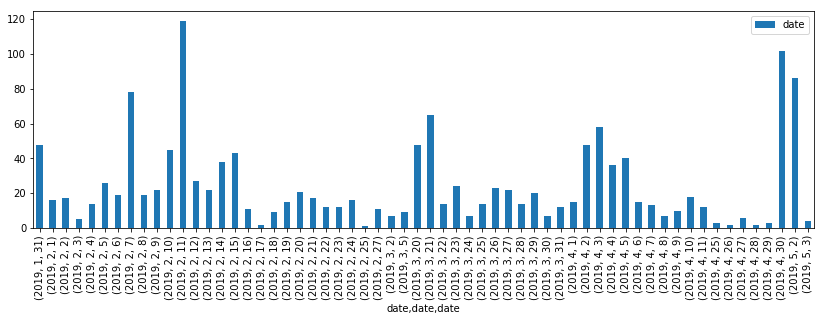

In [49]:
data1 = Dataset('Leafminers')
data1.read(data=data1.target_classes[0], loadmat=False)
inds_1 = test_inds(data1, dates=[(2019,4,30), (2019,5,2)], plot=True);

Data: LG_drosophila_10_09.
Read 5536 filenames in 0.12 seconds.
476


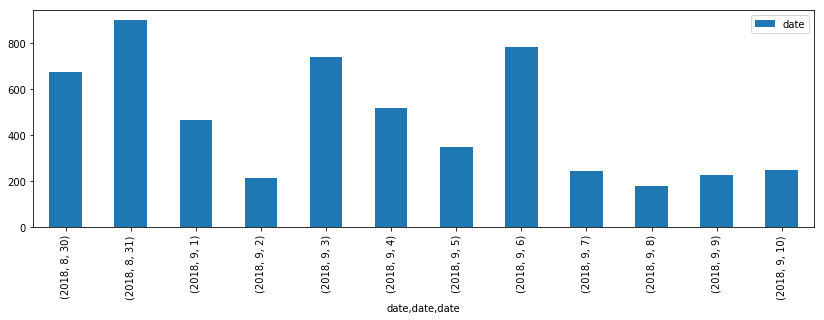

In [50]:
data2 = Dataset('LG')
data2.read(data=data2.target_classes[0], loadmat=False)
inds_2 = test_inds(data2, dates=[(2018,9,9), (2018,9,10)], plot=True);

Data: LG_zapr_26_09.
Read 7210 filenames in 0.12 seconds.
828


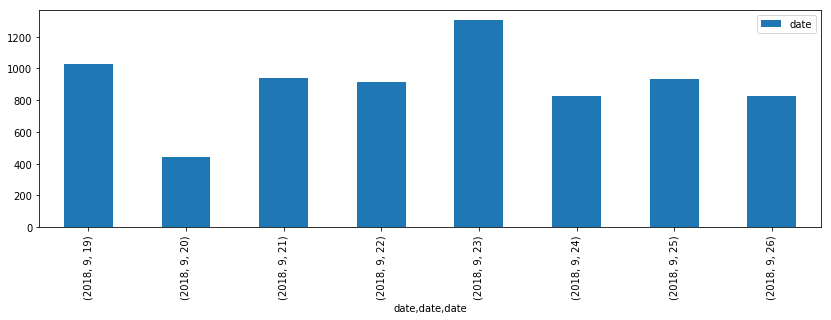

In [51]:
data3 = Dataset('LG')
data3.read(data=data3.target_classes[1], loadmat=False)
inds_3 = test_inds(data3, dates=[(2018,9,26)], plot=True);

Data: D. suzukii.
Read 6423 filenames in 0.06 seconds.
539


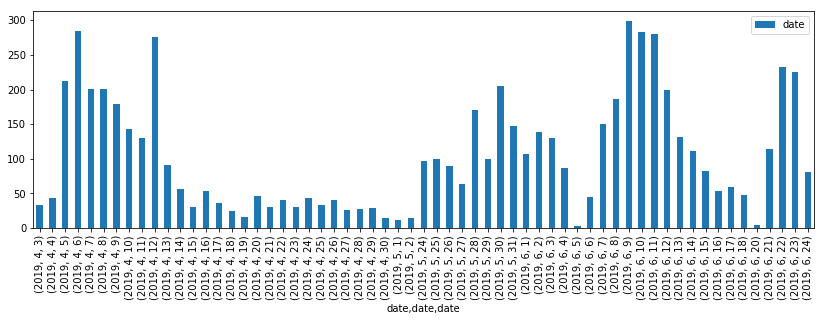

In [52]:
data4 = Dataset('Pcfruit')
data4.read(data=data4.target_classes[1], loadmat=False)
inds_4 = test_inds(data4, dates=[(2019,6,22),(2019,6,23),(2019,6,24)], plot=True);

## Creating TRAIN/VAL/TEST sets

In [53]:
def sub_test(dataset, inds):
    X = dataset.filenames.loc[~dataset.filenames.index.isin(inds)]
    y = dataset.y.loc[~dataset.y.index.isin(inds)]
    X_test = dataset.filenames.loc[dataset.filenames.index.isin(inds)]
    y_test = dataset.y.loc[dataset.y.index.isin(inds)]
    return X, y, X_test, y_test

x1, y1, xt1, yt1 = sub_test(data1, inds_1)
x2, y2, xt2, yt2 = sub_test(data2, inds_2)
x3, y3, xt3, yt3 = sub_test(data3, inds_3)
x4, y4, xt4, yt4 = sub_test(data4, inds_4)

In [54]:
X_test = pd.concat([xt1,xt2,xt3,xt4], axis=0).tolist()
y_test = pd.concat([yt1,yt2,yt3,yt4], axis=0).tolist()

In [ ]:
X = pd.concat([x1,x2,x3,x4], axis=0).tolist()
y = pd.concat([y1,y2,y3,y4], axis=0).tolist()

df = pd.DataFrame({"X": X, "y":y})
# df.drop(index=df[df['y'] == 'Ae. aegypti'].sample(38345).index.values, inplace=True)
X,y = df.X.values, df.y.values

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
y_test = le.fit_transform(y_test)

In [56]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X,y = shuffle(X,y, random_state=0)

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [58]:
print(pd.Series(y_train).value_counts())
pd.Series(le.inverse_transform(y_train)).value_counts()
# y_train

3    5174
1    4643
2    4054
0    1000
dtype: int64


LG_zapr_26_09          5174
D. suzukii             4643
LG_drosophila_10_09    4054
Chicorii               1000
dtype: int64

# Modelling

In [59]:
import tensorflow as tf
# import tf.keras as keras

In [64]:
from utils_train import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical
from wavhandler import *
import math

In [69]:
model_name='flies_validation' 
setting='raw'
top_weights_path = TEMP_DATADIR + str(model_name) + '.h5'
targets = len(np.unique(y_train))
batch_size = 32

# Build the Neural Network
model = Sequential()

model.add(Conv1D(16, 3, activation='relu', input_shape=(5000, 1)))
model.add(Conv1D(16, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(32, 3, activation='relu'))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(Conv1D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())

model.add(Dropout(0.5))
model.add(Dense(targets, activation='softmax'))

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

callbacks_list = [ModelCheckpoint(top_weights_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False),
    EarlyStopping(monitor = 'val_accuracy', patience = 6, verbose = 1),
    ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 3, verbose = 1),
    CSVLogger('model_' + str(model_name) + '.log')]

target_names = list(np.unique(y))

In [ ]:
model.fit_generator(train_generator(X_train, y_train, batch_size=batch_size,
                                   target_names=target_names,
                                   setting=setting),
                   steps_per_epoch = int(math.ceil(float(len(X_train)) / float(batch_size))),
                   epochs=100,
                   validation_data = valid_generator(X_val, y_val,
                                                    batch_size=batch_size,
                                                    target_names=target_names,
                                                    setting=setting),
                    validation_steps=int(math.ceil(float(len(X_test))/float(batch_size))),
                    callbacks = callbacks_list)

Epoch 1/100
309/465 [==================>...........] - ETA: 39s - loss: 0.1273 - accuracy: 0.9514

In [15]:
model.load_weights(top_weights_path)
y_pred = model.predict_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=batch_size, 
                                                    setting=setting, 
                                                    target_names=target_names),
        steps = int(math.ceil(float(len(X_test)) / float(batch_size))))

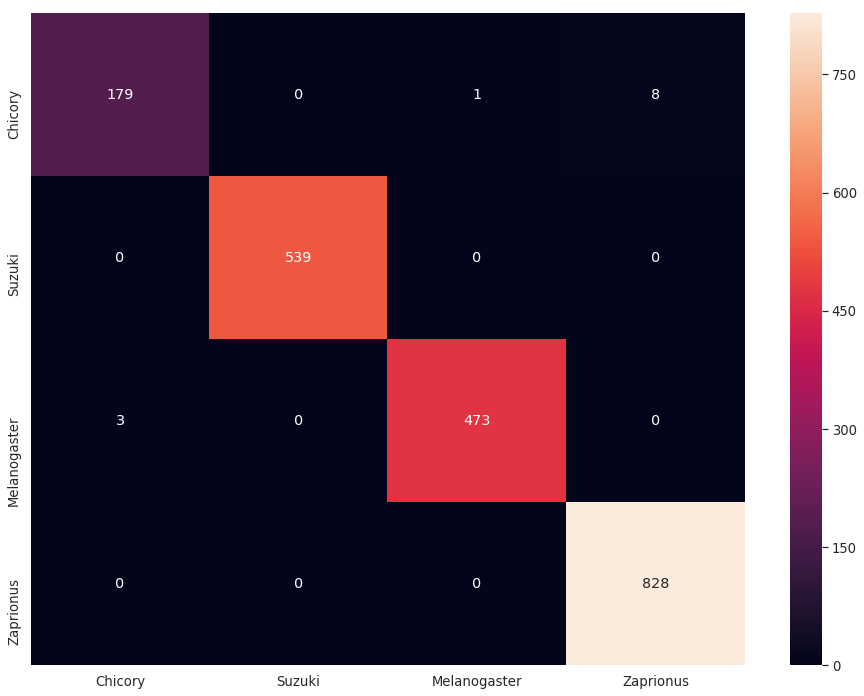

In [22]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
x = confusion_matrix(np.array(y_test), np.argmax(y_pred, axis=1))

plt.figure(figsize=(16,12))
sns.set(font_scale=1.2)
ticks = ['Chicory','Suzuki','Melanogaster','Zaprionus']
ticks_short = ['Chicory','Suzuki','Melanogaster','Zaprionus']
sns.heatmap(x, annot=True, fmt='.0f', xticklabels=ticks, yticklabels=ticks_short)

In [ ]:
model.load_weights(top_weights_path)
loss, acc = model.evaluate_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=batch_size, 
                                                    setting=setting, 
                                                    target_names=target_names),
        steps = int(math.ceil(float(len(X_test)) / float(batch_size))))

print('loss', loss)
print('Test accuracy:', acc)